In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm



In [5]:
# Define a function to generate clusters
def cluster_gen(n_clusters, pts_minmax=(100, 500), x_mult=(2, 7), y_mult=(2, 7), 
                             x_off=(0, 50), y_off=(0, 50)):

    # n_clusters = number of clusters to generate
    # pts_minmax = range of number of points per cluster 
    # x_mult = range of multiplier to modify the size of cluster in the x-direction
    # y_mult = range of multiplier to modify the size of cluster in the y-direction
    # x_off = range of cluster position offset in the x-direction
    # y_off = range of cluster position offset in the y-direction

    # Initialize some empty lists to receive cluster member positions
    clusters_x = []
    clusters_y = []
    labels = []
    # Generate random values given parameter ranges
    n_points = np.random.randint(pts_minmax[0], pts_minmax[1], n_clusters)
    x_multipliers = np.random.randint(x_mult[0], x_mult[1], n_clusters)
    y_multipliers = np.random.randint(y_mult[0], y_mult[1], n_clusters)
    x_offsets = np.random.randint(x_off[0], x_off[1], n_clusters)
    y_offsets = np.random.randint(y_off[0], y_off[1], n_clusters)

    # Generate random clusters given parameter values
    for idx, npts in enumerate(n_points):

        xpts = np.random.randn(npts) * x_multipliers[idx] + x_offsets[idx]
        ypts = np.random.randn(npts) * y_multipliers[idx] + y_offsets[idx]
        clusters_x.append(xpts)
        clusters_y.append(ypts)
        labels.append(np.zeros_like(xpts) + idx)

    # Return cluster positions and labels
    return clusters_x, clusters_y, labels

In [61]:
np.random.seed(10) # Change the number to generate a different cluster.

n_clusters = 3
clusters_x, clusters_y, labels = cluster_gen(n_clusters)

# Convert to a training dataset in sklearn format
X = np.float32((np.concatenate(clusters_x), np.concatenate(clusters_y))).transpose()
y = np.float32((np.concatenate(labels)))



In [62]:
# Create an instance of SVM and fit the data.
ker = 'rbf'
svc = svm.SVC(kernel=ker, C=1).fit(X, y)



Text(0.5, 1.0, 'SVC with rbf kernel')

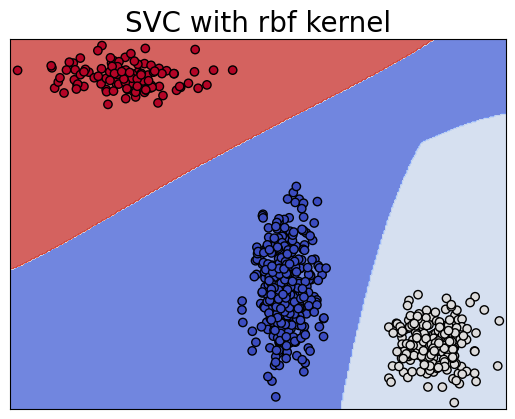

In [63]:
# Create a mesh that we will use to colorfully plot the decision surface
# Plotting Routine courtesy of: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py
# Note: this coloring scheme breaks down at > 7 clusters or so

h = 0.2  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # -1 and +1 to add some margins
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Classify each block of the mesh (used to assign its color)
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='black')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('SVC with '+ker+' kernel', fontsize=20)

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Convert from RGB to HSV using cv2.cvtColor()
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Compute the histogram of the HSV channels separately
    h_hist = np.histogram(hsv_img[:,:,0], bins=nbins, range=bins_range)
    s_hist = np.histogram(hsv_img[:,:,1], bins=nbins, range=bins_range)
    v_hist = np.histogram(hsv_img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((h_hist[0], s_hist[0], v_hist[0])).astype(np.float64)
    # Normalize the result
    norm_features = hist_features / np.sum(hist_features)
    # Return the feature vector
    return norm_features

In [4]:
# Define a function to extract features from a list of images
# Have this function call color_hist()
def extract_features(imgs, hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # Apply color_hist() 
        hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(hist_features)
    # Return list of feature vectors
    return features

In [26]:
# Read in car and non-car images
images = glob.glob('./data/*/*/*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

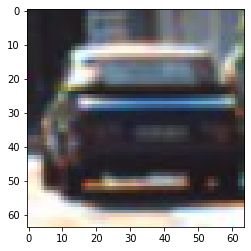

In [28]:
import matplotlib.pyplot as plt 
nc = mpimg.imread(cars[0])
plt.imshow(nc)

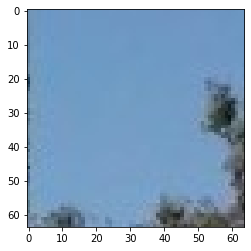

In [29]:
import matplotlib.pyplot as plt 
c = mpimg.imread(notcars[0])
plt.imshow(c)

In [ ]:
# TODO play with this value to see how your classifier
# performs under different binning scenarios
histbin = 32

car_features = extract_features(cars, hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


In [ ]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Dataset includes', len(cars), 'cars and', len(notcars), 'not-cars')
print('Using', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

In [ ]:
car_features[0]

In [ ]:
# Use a linear SVC 
svc = SVC(kernel='linear')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

In [ ]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [ ]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')